### Deep Learning Supervised Text Classification
- BiLSTM (BDA + TrDA)

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [ ]:
from numpy.random import seed
seed(156)
import tensorflow as tf
tf.random.set_seed(256)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [ ]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.std import tqdm
from IPython.display import display, HTML
import time
import textwrap
import json
import datetime

In [2]:
!pip list -v
# programmatically with python
#!python -m site --user-site
#!pip list --user -v

Package                       Version                Location                               Installer
----------------------------- ---------------------- -------------------------------------- ---------
absl-py                       1.3.0                  /usr/local/lib/python3.8/dist-packages pip
aeppl                         0.0.33                 /usr/local/lib/python3.8/dist-packages pip
aesara                        2.7.9                  /usr/local/lib/python3.8/dist-packages pip
aiohttp                       3.8.3                  /usr/local/lib/python3.8/dist-packages pip
aiosignal                     1.3.1                  /usr/local/lib/python3.8/dist-packages pip
alabaster                     0.7.12                 /usr/local/lib/python3.8/dist-packages pip
albumentations                1.2.1                  /usr/local/lib/python3.8/dist-packages pip
altair                        4.2.0                  /usr/local/lib/python3.8/dist-packages pip
appdirs                     

### Load Data

In [ ]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance',
    'mechanical or equipment issue'
    ]

fns = [
    '2209031206', # hydraulic fluid or oil leak
    '2210031444', # line strike
    '2210031122', # site compliance or practice issue
    '2210031323', # ppe non-compliance
    '2210032046'  # mechanical or equipment issue
]

fn_bd_aug_names = [
    'hydraulic fluid or oil leak_4700_simple_da',
    'line strike_8091_simple_da',
    'site compliance or practice issue_8000_simple_da',
    'ppe non-compliance_8050_simple_da',
    'mechanical or equipment issue_8294_simple_da'
]

fn_tr_aug_names = [
    'hydraulic fluid or oil leak_7920_trda',
    'line strike_8316_trda',
    'site compliance or practice issue_8410_trda',
    'ppe non-compliance_8034_trda',
    'mechanical or equipment issue_8085_trda'
    #'mechanical or equipment issue_8064_trda'
]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Load data from a minority category of interest
df = pd.read_csv(fn)
df = df[['text', 'category']]
df = pd.read_csv(fn)
df

Pick a category: mechanical or equipment issue


,text,category
0,foreign body entered employee l eye while grin...,0
1,drainage pipe damaged at two two m depth see s...,0
2,robodrill spider excavator being operated when...,0
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,other fall to lower level unspecified an emplo...,0
93854,injured by slipping or swinging object held by...,0
93855,direct exposure to electricity greater than tw...,0


### Data Preparation (Train / Test Splits)

In [ ]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

In [ ]:
base_train_count = len(X_train)
base_train_count

75085

In [ ]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

train_trues = list(y_train[y_train==1].index.values)
train_trues.sort()
print('Train:', len(train_trues), train_trues)

Test: 107 [172, 636, 697, 1357, 1391, 1559, 1646, 1750, 1779, 2048, 2229, 2400, 2535, 2562, 2906, 2970, 3405, 3441, 3498, 3540, 3724, 4047, 4085, 5068, 5253, 5354, 5425, 6035, 6036, 6431, 6460, 6791, 6800, 6837, 6846, 7054, 7159, 7258, 7382, 7441, 8803, 9344, 9596, 9826, 9859, 10132, 10159, 10183, 10601, 10746, 10781, 10845, 10921, 10956, 11008, 11310, 11431, 11474, 11612, 11924, 11974, 12487, 12798, 13599, 14171, 14563, 14836, 14892, 15064, 15429, 15495, 15965, 16503, 16627, 17129, 17477, 17873, 18192, 18441, 18781, 20462, 20903, 22108, 22634, 22831, 24435, 26734, 27209, 27890, 28339, 32475, 42017, 42478, 48405, 48522, 54196, 57556, 58480, 61912, 62836, 71018, 73961, 78574, 78585, 82365, 82534, 91838]
Train: 364 [149, 231, 240, 256, 282, 310, 320, 353, 396, 405, 415, 766, 792, 1142, 1381, 1399, 1446, 1582, 1684, 1781, 1786, 1856, 1971, 2072, 2263, 2347, 2407, 2464, 2477, 2544, 2586, 2603, 2709, 2822, 2861, 2870, 2921, 2923, 2940, 2966, 3039, 3072, 3316, 3439, 3493, 3561, 3647, 3660, 3

In [ ]:
# Look at training 'trues', i.e., rule-book hits
df_train_trues = df.iloc[train_trues]
df_train_trues

,text,category
149,crane cable damaged when big block was pulled ...,1
231,during the maneuver of a cherry picker in the ...,1
240,an installed post was found twisted and bent i...,1
256,damage found on vehicle unkown who caused vehi...,1
282,a pvc pipe and slip flange joint separated dur...,1
...,...,...
91223,other fall to lower level unspecified an emplo...,1
92858,direct exposure to electricity unspecified an ...,1
92988,direct exposure to electricity unspecified emp...,1
93453,contact with hot objects or substances an empl...,1


### **Basic Data Augmentation (BDA) Experiments**

In [ ]:
fn_bd_aug_names

['hydraulic fluid or oil leak_4700_simple_da',
 'line strike_8091_simple_da',
 'site compliance or practice issue_8000_simple_da',
 'ppe non-compliance_8050_simple_da',
 'mechanical or equipment issue_8294_simple_da']

In [ ]:
# Load fabricated reports
fn_bd_name = fn_bd_aug_names[index] 
df_fab = pd.read_csv(f'01_data/fabricated/{fn_bd_name}.csv')
print(f"Printing sample for '{fn_bd_name}'")
df_fab.sample(10)

Printing sample for 'mechanical or equipment issue_8294_simple_da'


,text,category
1763,an elkhorn subcontractor beleaguer at around a...,1
5305,wood employee discovered that wood truck milli...,1
3980,alleged a to fence overhead is incident tray r...,1
5935,crane auxillary hoist cable and sheave damaged...,1
5537,at approximately one chiliad three hundred hou...,1
2281,during a power outage in atyrau affecting the ...,1
2354,anele drip from lighting tower incident at app...,1
2755,client confined space standard nonconformance ...,1
7988,caught in die hard equipment or machinery duri...,1
1075,wg rigging personnel were attempting to lift a...,1


In [ ]:
# Prepare data & conbine with original training data
X_train_fab = df_fab.text
X_train_new = X_train.append(X_train_fab)
X_train_list = list(X_train_new)
y_train_list = list(y_train)

In [ ]:
# Complete the new training dataframe
df_shuff = pd.DataFrame(X_train_list, columns = ['text'])
y_train_list.extend([1 for i in range(len(X_train_fab))])
df_shuff['category'] = y_train_list
df_shuff

,text,category
0,ip operated air assisted door with left hand w...,0
1,twenty x spiders fell from roof when generator...,0
2,struck by discharged object or substance an em...,0
3,caught in running equipment or machinery n e c...,0
4,caught in running equipment or machinery durin...,0
...,...,...
83374,direct exposure to electricity unspecified emp...,1
83375,direct exposure to electricity unspecified emp...,1
83376,direct exposure to electricity unspecified emp...,1
83377,direct exposure to for unspecified employees w...,1


In [ ]:
# Shuffle the dataframe
df_shuff = df_shuff.sample(frac=1).reset_index(drop=True)
df_shuff

,text,category
0,struck against moving part of machinery or equ...,0
1,injured by slipping or swinging object held by...,0
2,conducting boring operations conduit for an el...,1
3,individual felt pain in his knee he visited th...,0
4,pedestrian struck by vehicle in nonroadway are...,0
...,...,...
83374,struck against stationary object or equipment ...,0
83375,other fall to lower level unspecified an emplo...,0
83376,struck by falling object or equipment n e c on...,0
83377,being by falling unspecified or equipment obje...,1


In [ ]:
# Visually check a random sample of 20 (hits)
df_shuff[df_shuff['category']==1].sample(20)

,text,category
31381,direct exposure to electricity unspecified an ...,1
70715,trace heating racing circuit breaker overheats...,1
69057,power outage on beatrice bravo incident at app...,1
45043,cool power outage due to down pat ipp trip inc...,1
61327,excavator operator struck an underground power...,1
2329,compressed or pinched by shifting objects top ...,1
26536,a damper for ventilation has been found damage...,1
75365,at just about four hundred and pm a short was ...,1
29866,loss of electrical power on beatrice bravo inc...,1
58029,nacap sub c were hollow a trench adjacent to t...,1


In [ ]:
X_train = df_shuff.text
y_train = df_shuff.category

### Transformer Data Augmentation (TrDA)

In [ ]:
# Load fabricated reports
fn_tr_name = fn_tr_aug_names[index] 
df_fab = pd.read_csv(f'01_data/fabricated/{fn_tr_name}.csv')
print(f"Printing sample for '{fn_tr_name}'")
df_fab.sample(10)

Printing sample for 'mechanical or equipment issue_8085_trda'


,text,group
7230,failed hosepipe on d10 excavator operator was ...,mechanical or equipment issue
2371,component failure in connection with electrica...,mechanical or equipment issue
7905,leaking connection to hydraulic hose on roadwa...,mechanical or equipment issue
7267,failed pump employee struck his head on line r...,mechanical or equipment issue
3867,hydraulic hose failed on hydraulic hose ruptur...,mechanical or equipment issue
566,hydraulic unit fault occurred during the remov...,mechanical or equipment issue
3292,bolt failed with part of boom causing it to tr...,mechanical or equipment issue
3280,bolt failed on trip on tlb accident 36167on ti...,mechanical or equipment issue
6244,plant broke down electrical system causing pow...,mechanical or equipment issue
4435,connector breakdown during excavation works du...,mechanical or equipment issue


In [ ]:
# Prepare data and augment raw (real) training data
X_train_fab = df_fab.text
X_train_new = X_train.append(X_train_fab)
X_train_list = list(X_train_new)
y_train_list = list(y_train)

In [ ]:
df_shuff = pd.DataFrame(X_train_list, columns = ['text'])
y_train_list.extend([1 for i in range(len(X_train_fab))])
df_shuff['category'] = y_train_list
df_shuff

,text,category
0,struck against moving part of machinery or equ...,0
1,injured by slipping or swinging object held by...,0
2,conducting boring operations conduit for an el...,1
3,individual felt pain in his knee he visited th...,0
4,pedestrian struck by vehicle in nonroadway are...,0
...,...,...
91459,faulty connection to fpso incident 31459at app...,1
91460,faulty connection to electrical lighting circu...,1
91461,faulty connection to power cable during instal...,1
91462,faulty connection fpso incident 33852on july t...,1


In [ ]:
# Shuffle the dataframe
df_shuff = df_shuff.sample(frac=1).reset_index(drop=True)
df_shuff

,text,category
0,struck by dislodged flying object particle two...,0
1,fire in building where wood lease ten appartme...,0
2,defective stop end edge protection on scaffold...,0
3,caught in running equipment or machinery durin...,0
4,burst hose failed resulting in a loss of power...,1
...,...,...
91459,overexertion involving outside sources unspeci...,0
91460,compressor fault due to aberrant exhaust gases...,1
91461,caught in running equipment or machinery durin...,0
91462,"pump broke down on two million, four hundred a...",1


In [ ]:
# Quick visual check of a random sample of 20 (hits)
df_shuff[df_shuff['category']==1].sample(20)

,text,category
27938,faulty connection to gasket hose causing minor...,1
33447,hydraulic hose broke down in front of deck cre...,1
16559,container swh was lifted using the platform cr...,1
67218,edmunson delivery driver wagon collided the co...,1
66198,the excavator on struck an underground power a...,1
5941,while conducting boring operations to install ...,1
25664,fence of contractor lay down damaged on world ...,1
37292,failed turbine cable damaged during assembly o...,1
59792,lift damage while operating eight hundred and ...,1
21162,engergised open ended the hose welder sunday e...,1


## Build Model

In [ ]:
# Load modelling building libraries
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'08_output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("03_embeddings/glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [ ]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    print('_words', len(word_index))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))

    # Attention addition
    #model.add(attention(return_sequences=True))
    
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=["categorical_accuracy"])
    return model

In [ ]:
X_train = df_shuff.text
y_train = df_shuff.category

print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [ ]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 72577
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 50)           3628900   
                                                                 
 bidirectional_8 (Bidirectio  (None, 500, 64)          21248     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_10 (Bidire

In [ ]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1].sample(20)

15965    whilst walking across the seafox two gangway t...
10159    a mechanical fitter was torquing bolts up on a...
42478    injured by slipping or swinging object held by...
3724     failure of tugger winch control incident 34408...
6800     mech tradesman reported to the medic with pain...
17129    channel head nozzle was found bent when liftin...
20462    crane outrigger base plate dislodged from the ...
4085     power outage on beatrice bravo incident 34028a...
4047     hb1117 hydraulic fitting leak on starboard cra...
7382     ro equipment failure involving contractor cont...
42017    ignition of vapors gases or liquids an employe...
3441     wg rigging personnel were attempting to lift a...
14171    heat damage to electrical cable plug and socke...
1646     nacap sub c were excavating a trench adjacent ...
10845    potential electrical cable damage the supporti...
1559     excavator suffered a hydraulic fitting failure...
2906     electrician cut through a control cable extra .

In [ ]:
# Reminder of test set breakdown
Counter(y_test)

Counter({0: 18665, 1: 107})

In [ ]:
# Verify augmented training set breakdown
Counter(y_train)

Counter({0: 74721, 1: 16743})

### Model Training & Evaluatrion

In [ ]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [ ]:
# In development mode, we only evaluate performance on validation data
# This means a 10% (here) of training data is used for validation during development
# When final model is ready, we can re-train on 100% of the training data and report
# final performance.
dev_or_final = input('Develop (d) or final model (f):')

if dev_or_final == 'd':
    # Split training into training and validation data
    X_train_vGlove, X_val_Glove, y_vtrain, y_val = train_test_split(X_train_Glove, y_train, test_size = 0.1, stratify=y_train, random_state = 1234)

    # Verify stratification
    num_pos_vTrain = len(y_vtrain[y_vtrain==1])
    print(f'Number of positives in training (val) split: {num_pos_vTrain}')

    num_pos_val = len(y_val[y_val==1])
    print(f'Number of positives in validation data: {num_pos_val}')

elif dev_or_final == 'f':
    # Do not split training, use 100% for final model check
    print(f'Training data has NOT been split.')
    X_train_vGlove, X_val_Glove, y_vtrain, y_val = X_train_Glove, X_test_Glove, y_train, y_test

Develop (d) or final model (f):d
Number of positives in training (val) split: 15069
Number of positives in validation data: 1674


Train new model (n) or load existing (l):n
Training for: mechanical or equipment issue
Enter epoch number (default is 3): 3
Epoch 1/3
644/644 [==============================] - 2026s 3s/step - loss: 0.1811 - categorical_accuracy: 0.8281 - val_loss: 0.0716 - val_categorical_accuracy: 0.8140
Epoch 2/3
644/644 [==============================] - 2005s 3s/step - loss: 0.0591 - categorical_accuracy: 0.8126 - val_loss: 0.0324 - val_categorical_accuracy: 0.8173
Epoch 3/3
644/644 [==============================] - 2015s 3s/step - loss: 0.0281 - categorical_accuracy: 0.8157 - val_loss: 0.0406 - val_categorical_accuracy: 0.8210


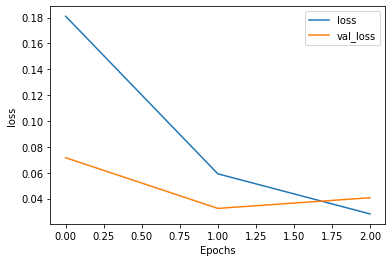

In [ ]:
train_or_load = input('Train new model (n) or load existing (l):')
if train_or_load == 'n':
    # Train the model
    print('Training for:', focus_cat)
    epoch_num = int(input('Enter epoch number (default is 3): '))
    history = model.fit(X_train_vGlove, y_vtrain,
                                validation_data=(X_val_Glove, y_val),
                                epochs=epoch_num,
                                batch_size=128,
                                verbose=1)
    
    # Plot training history
    plot_graphs(history, 'loss')
else:
    # load the model from disk
    fname = input('Specify filename (with extension):')
    filename = f'08_output/models/{fname}'
    model = pickle.load(open(filename, 'rb'))

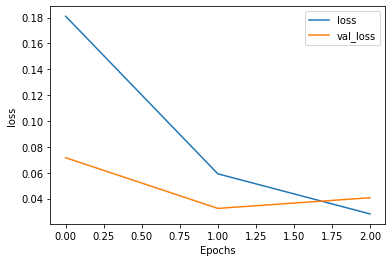

In [ ]:
# Plot training history
plot_graphs(history, 'loss')

In [ ]:
# Print accuracy measures
print(f'\n Evaluating Model for "{focus_cat}"... \n')

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")


 Evaluating Model for "mechanical or equipment issue"... 

587/587 [==============================] - 230s 388ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18665
           1       0.54      0.90      0.67       107

    accuracy                           0.99     18772
   macro avg       0.77      0.95      0.83     18772
weighted avg       1.00      0.99      1.00     18772





In [ ]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values
rbm_count = len(tmp[tmp['rule_book']==1])

# Quick look at predicted positives
print(f'Check rule-book hit count: {rbm_count}')

Check rule-book hit count: 107


In [ ]:
# Examine precision stats
# Look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
table.to_csv(f'10_performance/model_{focus_cat}_bda_trda_fps.csv')
display(HTML(table.to_html()))
total_pos_preds = len(tmp[(tmp['pred']==1)])
total_pos_hits = len(tmp[(tmp['pred']==1) & (tmp['rule_book']==1)])
print(f'\nThere are {len(table)} false positives...')
print(f'\nTotal no. of positive predictions is  {total_pos_preds}...')
print(f'\nTotal no. of positive hits is {total_pos_hits } vs {rbm_count} (in rule-book)...')

,text,pred,rule_book
5226,employee pinched finger between wrench handle and pipe when opening valve incident 31830employee was opening a valve with a crescent wrench the wrench slipped and he pinched his left pinky finger between wrench and pipe see detailed description,1,0
5544,workers arrived to work to find a gator utv had been damaged over the weekend the front fender was broken no one witnessed or reported the event to sbi claiming responsibility incident 31572workers had parked a utility vehicle john deere gator adjacent to the tool trailer to be stored over the weekend while workers were off site at some point over the weekend the gator was used by another trade without sbi knowledge and returned to its parked location damaged the supervisor on site held a discussion with the crew to attempt to locate the responsible party as well as discussed with other trades and was unsuccessful in locating the individual responsible for the damage damage was restricted to a broken front fender the damaged unit is rental unit see detailed description,1,0
11018,joint discovered unrecorded joint on sh1 system broken a task for reinstatement of mol pump one discharge control valve xzv241009 identified that a joint on drain valvehv241017 had been broken without being recorded on the hydratight database reported to the startup team applied ji1 and commenced investigation,1,0
15774,"while tightening bolts drive on impact wrench broke causing socket to fall to ground ee was tightening bolts above a large tank on pm1 conveyer support system when the thirty-four drive on a ingersoll rand seven hundred and two thousand, nine hundred and fifty-five pneumatic impact wrench broke causing the one fourteen socket to fall approximately twenty feet to the ground area below was barricaded part of the retaining ring was still in place on the drive one ee immediately reported incident to his supervisor and the safety dept two woodstock was contacted and impact wrench is being sent to david garcia for complete evaluation and recommendations",1,0
24573,during trenching works damage occurred to a pit containing unenergised electrical cables during trenching works damage occurred to a pit containing unenergised electrical cables no damage to the cables sustained work stopped and investigation commenced,1,0
53814,direct exposure to electricity greater than two hundred and twenty volts an employee was clipping in a new conductor on an existing distribution line when a phase to ground fault occurred causing an electrical flash that burned his left arm and shoulder,1,0
13652,hydraulic hose burst during quarry works a hydraulic pipe on the hose burst causing a spillage of hydraulic fluid to the ground within the quarry area spill kits deployed and clean up of contaminated stone to take place by hodge plant,1,0
514,faulty hydraulic hose hydraulic hose failed resulting in approximately one gallon of hydraulic fluid exiting the equipment spill kit and clean up materials were immediately deployed impacted materials were properly separated labelled and taken to the warehouse to be stored while waiting for transport off site,1,0
6873,hb102016 component failure within accommodation light fitting incident 30184hummingbird fpso 12th april two thousand and sixteen ten forty-five on the 12th april two thousand and sixteen two electrical techs were conductingdetailed inspection of ex equipment and lighting within the accommodation area during the inspection the technician wasaware of odour similar to that of hot plastic on further investigation thetechs identified a failed component part within the light fitting the fully encapsulated electronic control module ballast appears tohave suffered internal component failure resulting in a breakdown of the encapsulatingmaterial further investigation will be required to identify the root because ofthe initial failurethe light fitting contains a resin bonded electronic ballast acomponent failure within the enclosed housing has resul


There are 83 false positives...

Total no. of positive predictions is  179...

Total no. of positive hits is 96 vs 107 (in rule-book)...


In [ ]:
# Take a look at predicted negatives that had a rule-book hit
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

,text,pred,rule_book
6460,technician disconnected a live twenty-four volt circuit which was beyond the permit task incident 30619on 13th june two thousand and sixteen whilst undertaking wiring work in a junction box for a project on cats terminal a construction technician disconnected a live twenty-four volt circuit the circuit was for a smoke detector in the control room hvac system a line fault alarm annunciated on the dcs alerting the cro who in consultation with an instrument technician identified the because and stopped the work the wiring was reinstated the circuit disconnected was not part of the project work scope or covered by the permit but the technician was attempting an opportunistic repair of a damaged cable sleeve and believed that the entire junction box was isolated the likelihood of a mistake was increased by confusion over the work scope for the task on that day the wcc was a nonspecific permit to cover destruction activities under the project the permit issuer relied on the spa the supervisor and the pa to accurately describe the work scope through the work pack and the tool box talk the supervisor intended that a limited scope be completed however the scope the supervisor believed he had conveyed to the pa and the work party was not reflected in the task chunks written on the tool box talks the spa believed that the full scope was being carried out the work pack that was with the work party also contained loop drawings showing the full scope see detailed description,0,1
11008,extension cable plug burneddamaged worker plugged in an extension cord when the plug shorted and tripped the rcd breaker resulting in minor damage to the extension cable plug the extension lead was tagged out of service and returned to the tool store incident reported to supervisor,0,1
26734,a fitter using a spanner to do torqueing in a screwnut above his head was hit on his mouth when the spanner detached from de bolt during the night shift around 22h a wood fitter was tightening some boltnut systems to install cable tray supports he was using two thirty-four spanners one to stop the screw turning and the other to tight the nut when in a given moment the spanner detached from the bolt and hit the ip on his mouth causing a small tooth break and a small cut on the inner side of the lower lip the actual severity was chosen as b2 mtc and the most reasonable potential was also a b2 rwc as the recovery may need him to work onshore after tooth treatment the employee went by foot to the offshore hospital at floatel victory received first aid cares from the nurse technician on duty offshore and was released from his tasks to rest as that was his last night of the shift he will be disembarked today march 11th and sent to a dentist for the tooth treatment and xray and after to focus to be evaluated by their dentist no xray at focus rio,0,1
2970,"a pipe ruptured in the bathroom causing flooding of the engineering area restoration team called in damage at this time is unknown engineering area is closed and non operational ops mgr hssea working in other areas hssea to oversee clean up incident 36220upon entry to building at six hundred operations manager noticed water all over floor water came form men bathroom when investigated it seems the water piper bringing fresh water to building had broke flooding the entire engineering area water is at least two deep operations manager had building power cut to the area to avoid electrocution area is now unworkable waiting for disaster relief from belfore to arrive will access damage and report upon further investigation eleven thousand, two hundred and eighteen water mitigation has been resolved and floor is dry as are most of the drywall most work to do now is cosmetic as there are holes punched into bottom of drywall to vent with air to aid in drying and replacing the lower molding phil brunton has been notified and is working with the cec operations manager for insurance purposes see detailed descripti


There are 11 entries (out of 107)...


In [ ]:
# Save the model
filename = f'08_output/models/{time.strftime("%y%m%d%H%M")}_{focus_cat}_bilstm_bda_trda_{epoch_num}_model.pkl'
pickle.dump(model, open(filename, 'wb'))

## Addendum Checks - Method Comparison
Check performance on a new set of unseen data. This data was recieved after models were trained and tested. This data was also unseen by the rule-book method hence will be useful for a comparison between the two methods.

In [ ]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance',
    'mechanical or equipment issue'
    ]

fns = [
    '2211111006', # hydraulic fluid or oil leak
    '2211131407', # line strike
    '2211121050', # site compliance or practice issue
    '2211121130', # ppe non-compliance
    '2211131420'  # mechanical or equipment issue
]

# Select a category to load
pick = input('Pick a category (e.g., site compliance or practice issue): ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Load data from a minority category of interest
df = pd.read_csv(fn)
df = df[['text', 'category']]
df = pd.read_csv(fn)
df

Pick a category (e.g., site compliance or practice issue): mechanical or equipment issue


,text,category
0,person tested positive to covid nineteen in ca...,0
1,scaffolder struck thumb with hammer causing mi...,0
2,ip reported eye irritation whilst working on t...,0
3,wood employee tested antigen rapid test art po...,0
4,one one massy wood employee tested positive fo...,0
...,...,...
2424,a managed contractor employee tested positive ...,0
2425,cp20220043 env nanjv release of silt laden wat...,0
2426,cut to knee when ascending staircase individua...,0
2427,one wood employee tested positive for covid19 ...,0


In [ ]:
# Now create the input to the model training stage
X_test = df.text
y_test = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

In [ ]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

Test: 11 [100, 149, 190, 291, 417, 448, 752, 1682, 2106, 2196, 2268]


In [ ]:
MAX_NB_WORDS=75000
MAX_SEQUENCE_LENGTH=500
all_text = np.array(X_test)

# Fit tokeniser only on training text
text = np.array(X_train)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text)

sequences = tokenizer.texts_to_sequences(all_text)

# Get a list of all words and their sequence numbers
word_index = tokenizer.word_index

# Pad out the sequences with zeroes to max sequence length
all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Make filename consistent
X_test_Glove = all_text

In [ ]:
# Print accuracy measures
print(f'\n Evaluating Model for "{focus_cat}" with new data ... \n')

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")


 Evaluating Model for "mechanical or equipment issue" with new data ... 

76/76 [==============================] - 29s 362ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2418
           1       0.07      0.27      0.12        11

    accuracy                           0.98      2429
   macro avg       0.53      0.63      0.55      2429
weighted avg       0.99      0.98      0.99      2429





In [ ]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  11


In [ ]:
# Examine precision stats
# Look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
outta = tmp[(tmp['pred']==1)]
display(HTML(table.to_html()))
total_pos_preds = len(tmp[(tmp['pred']==1)])
outta.to_csv(f'10_performance/{focus_cat}_{total_pos_preds}_bda_trda_addendum_checks.csv')
total_pos_hits = len(tmp[(tmp['pred']==1) & (tmp['rule_book']==1)])
print(f'\nThere are {len(table)} *false* positive entries...')
print(f'\nTotal no. of positive predictions is  {total_pos_preds}...')
print(f'\nTotal no. of positive hits is  {total_pos_hits }...')

,text,pred,rule_book
93,"small contusion to right 5th digit little finger on nineteen october two thousand and twenty-two at approximately one thousand, six hundred and ten an sbi employee was cleaning out the screen deck on the triple deck screen plant located on the facility pad the employee was wearing all required ppe while cleaning clearing debris the employee right little finger was pinched between the pry bar and the side rail of the screen deck resulting in a small contusion to the base of the right little finger basic first aid was provided and the employee was released back to work the employee stopped work and immediately notified safety of the incident basic first aid was administered and the employee was released back to work",1,0
123,during air blowing activity air hose dislodged from the hose tail adapter about fifteen minutes into the air blowing activity air hose dislodged from the hose tail adapter whip arrestor was installed correctly which arrested the hose from whipping nobody was injured stopped work notified plant shift superintendent initiated investigation process,1,0
188,valve assembly failed during pressure test client operations team two client one wood seconded employee were in the process of completing a pressure test of the high pressure hp manifold the operations team completed closing the upper diverter valve on b1663 when the valve handle gear box cap which weighs approximately twenty-seven kg separated and travelled a distance of thirteen feet and made contact with the platform structure the system pressure was approx two hundred and twenty bar at the time this is classed as a b1 first aid although there were no injuries or damage to wood property potential is assessed as b5 fatality as the workers were in the line of fire when the assembly failed all work suspended,1,0
248,e7271common fuel gas heater 72pshh707 failed to operate during pm during routine pm of sil one pressure switch the switch failed to activate switch function is to prevent fuel gas entering hot oil system following a tube rupture event the switch type was sirco switch site has frequent failures or sirco switches and ongoing investigation is ongoing in atms to investigate replacement of key sirco switches switch was removed and overhauled and is now functioning ongoing atms investigation currently active to explore the sirco switches,1,0
259,excavator bucket impacted existing underground low voltage instrument cable at approximately 1100am on tuesday 20th september the civil contractor was tasked with excavation works for icr foundation the conditions were clear and sunny with no visual issues identified during the excavation the excavator bucket impacted an existing live low voltage fire and gas instrument cable the impact was minimal due to the protection of the corrugated pvc sleeve that was housing the cable no red concrete was visible during the excavation the standby electrical excavation guard was present during the incident and informed the civil team to stop work and also make the area safe no issues occurred in relation to the refinery operations due to the refinery currently undergoing turnaround activities excavation stopped immediately area made safe with electrical excavation guard present informed wood electrical and civil superintendents client operations also informed,1,0
284,nan nan works suspended incident area secured investigation commenced,1,0
310,"two wood ee were engaged in a physical altercation on monday nine million, one hundred and twenty-two thousand and twenty-two 1700pm two wood employees were involved a verbal altercation which escalated to a physical altercation the two wood ee were involved in a discussion of nonwork related topics when the discussion progressed to a verbal altercation wood ee1 gathered their personal belongings and attempted to leave the work area when wood ee2 blocked their exit from the work area and attempted to put their hands on wood ee1 wood ee1 requested wood ee2 to 


There are 38 *false* positive entries...

Total no. of positive predictions is  41...

Total no. of positive hits is  3...


In [ ]:
# Take a look at predicted negatives that had a rule-book hit
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

,text,pred,rule_book
99,dirt shaker being moved by excavator tipped over wood employees were moving a dirt shaker from the north side of utility building using a twenty-two excavator with one wire rope and shackle to move this equipment it needed to be raised two ft from lift point so that back tires could come in contact with ground in order to roll when the equipment was raised since the ground was at a slight incline it rolled backwards and the tires on the north side went onto a big rock shaker rolled over onto the south side south side is heavier side of shaker no injuries and spotters were in place to prevent encroachment of personnel during move work stopped diesel fuel leak contained team debriefed and planning started to upright equipment,0,1
195,"injured person stepped on a rock slightly twisted knee employee was carrying two two jugs of diesel exhaust fluid def to put into equipment the ground was level but rocky employee stepped on a rock turning his foot and causing a pain in his right knee there was slight swelling and low pain when walking just below the inside of his right knee employee continued to work until seen limping by another employee who then instructed him to report the incident to the safety department ice was applied by the hsse department in the office on twenty minute intervals until employee felt he could walk without pain first aid treatment only one million, fifty-two thousand and twenty-two employee reported to work and states his knee is without pain and he is able to work",0,1
441,"the excavator broke a water supply line and causing water leakage while excavating on august 23rd two thousand and twenty-two at seven fifty a m the construction contractor qian received a work permit to conduct excavation work with excavators on the south side of the preparation ws structure eight hundred and five a m when excavating to the southwest corner of the structure the excavator broke a water supply line branch pipe that was buried about a half meter underground causing water leakage the construction manager immediately reported the matter to the owner maintenance manager and asked for help in closing the valve and cutting off the water eight fifteen a m when the water valve was closed the construction contractor began to organize pumping water and repair the water pipe nine hundred and fifty-five a m pumping water completed and plugging water wang jun began to coordinate the repair at this point the water supply was cut off for about two hours one thousand, four hundred and fifty a m the constructor construction manager continues to organize an excavation search for the water supply main line the owner clarification pipeline buried depth is about one two m after digging 1m deep then prepare for manual digging after mechanical cleaning of the soil but the excavator still carried on digging the soil and touched the water supply main line causing leakage the construction manager contacted the owner maintenance manager to shut off the valve water and then organize to repair the pipe one thousand, five hundred and thirty a m pumping water was complete and plugging the water supply was cut off for about half an hour one stopped the excavation work immediately2 investigated the incident three conducted time out for the safety",0,1
512,diesel leak from pec diesel tank truck diesel truck operator worker were filling diesel to a 70ton crane the worker accessed the crane fuel tank to commence filling while the diesel truck operator turned the isolation valve to the open position after filling for about five minutes diesel started to leak at the connection of the flow meter the diesel truck operator shut off the isolation valve final reading of flowmeter was concluded that five liters of diesel spilled to the concrete ground diesel top up operation was stopped absorbent pads were deployed to contain and clean up spill incident was cascaded to wood hsse department,0,1
552,front tipping mini dumper truck inadvertentl


There are 9 entries (out of 31)...
